<a href="https://colab.research.google.com/github/elemnurguner/data-ai-projects/blob/main/Sahtekarl%C4%B1k_Tespiti_(Fraud_Detection).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sahtekarlık Tespiti (Fraud Detection)
•	Amaç: Finansal işlemlerde sahtekarlığı tespit etme.
•	Veri Seti: Kaggle'dan Credit Card Fraud Detection veri seti.
•	Adımlar:
1.	Veriyi yükle ve dengesiz veri sorununu çöz (örneğin, SMOTE).
2.	Anomali tespiti algoritmaları (Isolation Forest, Autoencoders) kullan.
3.	Model performansını değerlendir


In [ ]:
import numpy as np  # Bu satırı ekliyoruz!

In [ ]:
import pandas as pd

# Veri setini direkt olarak yükleme (Kaggle API gerektirmez)
url = "https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv"
data = pd.read_csv(url)

# Veriyi kontrol edelim
print(data.head())
print("\nFraud Dağılımı:\n", data['Class'].value_counts())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

1. Veri Ön İşleme
A) Özellikler ve Hedef Değişkeni Ayırma

In [ ]:
X = data.drop('Class', axis=1)  # Özellikler (V1-V28, Time, Amount)
y = data['Class']              # Hedef değişken (0: Normal, 1: Sahtekarlık)

B) Veriyi Eğitim ve Test Setlerine Ayırma


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Eğitim seti boyutu:", X_train.shape)
print("Test seti boyutu:", X_test.shape)

Eğitim seti boyutu: (227845, 30)
Test seti boyutu: (56962, 30)


2. Dengesiz Veri Sorununu Çözme (SMOTE)


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("\nSMOTE Sonrası Sınıf Dağılımı:")
print(y_resampled.value_counts())


SMOTE Sonrası Sınıf Dağılımı:
Class
0    227451
1    227451
Name: count, dtype: int64


Not: SMOTE sadece eğitim setine uygulanır. Test setine dokunmuyoruz!



3. Anomali Tespiti Modelleri
Seçenek A: Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest

# Modeli eğit (contamination=sahtekarlık oranı tahmini)
model_if = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
model_if.fit(X_resampled[y_resampled == 0])  # Sadece normal işlemlerle eğitim

# Test setinde tahmin yap
y_pred_if = model_if.predict(X_test)
y_pred_if = [1 if x == -1 else 0 for x in y_pred_if]  # -1 = anomaly

Seçenek B: Autoencoder (Derin Öğrenme)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Model mimarisi
autoencoder = Sequential([
    Dense(16, activation='relu', input_shape=(X_resampled.shape[1],)),
    Dense(X_resampled.shape[1], activation='sigmoid')
])
autoencoder.compile(optimizer='adam', loss='mse')

# Sadece normal işlemlerle eğitim (y_resampled == 0)
autoencoder.fit(X_resampled[y_resampled == 0], X_resampled[y_resampled == 0],
                epochs=10, batch_size=32)

# Test setinde anomali skorları hesapla
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)
y_pred_ae = [1 if e > np.percentile(mse, 95) else 0 for e in mse]  # MSE'ye göre threshold

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7108/7108 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 374599584.0000
Epoch 2/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 375346304.0000
Epoch 3/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 374379040.0000
Epoch 4/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 375772960.0000
Epoch 5/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 376831968.0000
Epoch 6/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 376100384.0000
Epoch 7/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 375041600.0000
Epoch 8/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 376636992.0000
Epoch 9/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 375071168.0000
Epoch 10/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 374563072.0000
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 968us/step


4. Model Performansını Değerlendirme


Isolation Forest Performansı:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.68      0.17        98

    accuracy                           0.99     56962
   macro avg       0.55      0.84      0.58     56962
weighted avg       1.00      0.99      0.99     56962



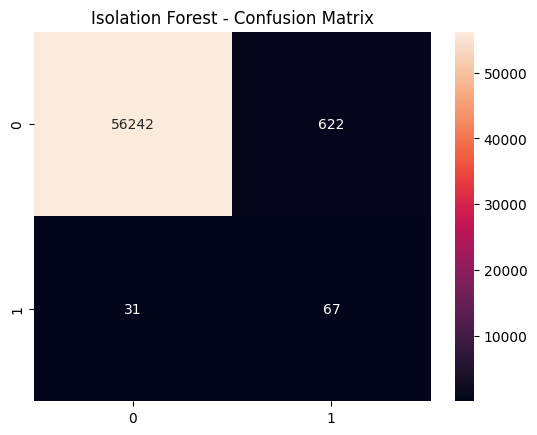


Autoencoder Performansı:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56864
           1       0.00      0.01      0.00        98

    accuracy                           0.95     56962
   macro avg       0.50      0.48      0.49     56962
weighted avg       1.00      0.95      0.97     56962



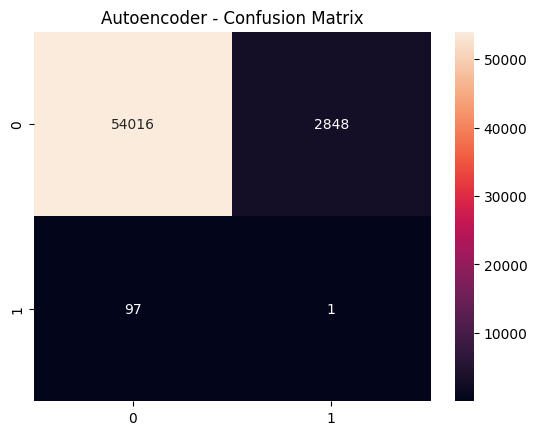

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Isolation Forest için
print("Isolation Forest Performansı:")
print(classification_report(y_test, y_pred_if))
sns.heatmap(confusion_matrix(y_test, y_pred_if), annot=True, fmt='d')
plt.title('Isolation Forest - Confusion Matrix')
plt.show()

# Autoencoder için
print("\nAutoencoder Performansı:")
print(classification_report(y_test, y_pred_ae))
sns.heatmap(confusion_matrix(y_test, y_pred_ae), annot=True, fmt='d')
plt.title('Autoencoder - Confusion Matrix')
plt.show()